In [1]:
!pip install pandas numpy scikit-learn matplotlib joblib openpyxl

In [2]:
!pip install "camelot-py[cv]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [4]:
import pandas as pd
import camelot
import re
import numpy as np

def clean_month_columns(df, months):
    df = df.copy()  # <- add this line
    for m in months:
        if m in df.columns:
            df[m] = (
                df[m]
                .astype(str)
                .str.replace(",", ".", regex=False)
                .str.replace(r"[^0-9.\-]", "", regex=True)
            )
            df[m] = pd.to_numeric(df[m], errors="coerce")
    return df



def extract_cpi_index(pdf_path):
    tables = camelot.read_pdf(pdf_path, pages="all", flavor="lattice")
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

    idx_table = None
    for t in tables:
        df = t.df
        # Look for table with "CPI headline index numbers" and "Dec 2024 = 100"
        if (any("CPI headline index numbers" in str(x) for x in df.values) or
            any("Dec 2024 = 100" in str(x) for x in df.values)):
            idx_table = df
            break

    # If not found by header, use the first table that has Year and month columns
    if idx_table is None:
        for t in tables:
            df = t.df
            if (any("Year" in str(x) for x in df.iloc[0].values) and
                any("Dec" in str(x) for x in df.iloc[0].values)):
                # Check if values look like index numbers (larger values)
                test_vals = df.iloc[1:5, 1:].values.flatten()
                numeric_vals = []
                for val in test_vals:
                    try:
                        num = float(str(val).replace(',', '.').replace(' ', ''))
                        if num > 10:  # Index values are generally large
                            numeric_vals.append(num)
                    except:
                        pass
                if len(numeric_vals) > 5:
                    idx_table = df
                    break

    if idx_table is None:
        print(" CPI index table not found")
        return pd.DataFrame()

    # Find the header row index by looking for "Year"
    header_row_idx = -1
    for i, row in idx_table.iterrows():
        if any("Year" in str(cell) for cell in row.values):
            header_row_idx = i
            break

    if header_row_idx == -1:
        print(" 'Year' header not found in identified index table")
        return pd.DataFrame()

    idx_table.columns = idx_table.iloc[header_row_idx]
    idx_table = idx_table.drop(header_row_idx).reset_index(drop=True)

    # Ensure 'Year' column exists after setting header
    if "Year" not in idx_table.columns:
         print(" 'Year' column not found after setting header in index table")
         return pd.DataFrame()


    keep_cols = [col for col in ["Year"] + months if col in idx_table.columns]
    idx_table = idx_table[keep_cols]
    idx_table = clean_month_columns(idx_table, months)

    cpi_idx = idx_table.melt(id_vars="Year", var_name="Month", value_name="CPI_Index")
    cpi_idx["Year"] = pd.to_numeric(cpi_idx["Year"], errors="coerce")
    cpi_idx = cpi_idx.dropna(subset=["CPI_Index", "Year"])
    # Convert month to title case before creating datetime
    cpi_idx["Month"] = cpi_idx["Month"].str.title()
    cpi_idx["date"] = pd.to_datetime(cpi_idx["Year"].astype(int).astype(str) + "-" + cpi_idx["Month"],
                                     format="%Y-%b", errors="coerce")
    cpi_idx = cpi_idx.dropna(subset=["date"]).set_index("date").sort_index()
    cpi_idx = cpi_idx[cpi_idx.index.year >= 2012]
    return cpi_idx[["CPI_Index"]]


def extract_cpi_yoy(pdf_path):
    tables = camelot.read_pdf(pdf_path, pages="all", flavor="lattice")
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

    yoy_table = None
    for t in tables:
        df = t.df
        # Look for table with "CPI headline year-on-year rates"
        if (any("CPI headline year-on-year rates" in str(x) for x in df.values) or
            any("year-on-year rates" in str(x).lower() for x in df.values)):
            yoy_table = df
            break

    # If not found by header, use table that has Year and month columns with smaller percentage values
    if yoy_table is None:
        for t in tables:
            df = t.df
            # Find the row that contains "Year" and at least one month as column headers
            header_row_idx = -1
            for i, row in df.iterrows():
                if any("Year" in str(x) for x in row.values) and any(m in str(x) for m in months for x in row.values):
                    header_row_idx = i
                    break

            if header_row_idx != -1:
                # Set columns and clean data
                df.columns = df.iloc[header_row_idx]
                df = df.drop(header_row_idx).reset_index(drop=True)

                if "Year" not in df.columns:
                    # If 'Year' is not exactly matched, try to find a similar column
                    year_col = None
                    for col in df.columns:
                        if isinstance(col, str) and "year" in col.lower():
                            year_col = col
                            break
                    if year_col:
                        df = df.rename(columns={year_col: "Year"})
                    else:
                        continue # Skip this table if no year-like column found


                tmp = clean_month_columns(df.copy(), months)

                # Check if values look like inflation percentages (smaller values, can be negative)
                test_vals = tmp.iloc[1:10, 1:].values.flatten()
                numeric_vals = []
                for val in test_vals:
                    try:
                        num = float(val)
                        # Inflation rates are typically between -10 and 30%
                        if -10 <= num <= 30:
                            numeric_vals.append(num)
                    except:
                        pass

                if len(numeric_vals) > 15:
                    yoy_table = df
                    break


    if yoy_table is None:
        print(" CPI YoY table not found")
        return pd.DataFrame()

    # Ensure 'Year' column exists before proceeding
    if "Year" not in yoy_table.columns:
         print(" 'Year' column not found in identified YoY table")
         return pd.DataFrame()


    keep_cols = [col for col in ["Year"] + months if col in yoy_table.columns]
    yoy_table = yoy_table[keep_cols]
    yoy_table = clean_month_columns(yoy_table, months)

    cpi_yoy = yoy_table.melt(id_vars="Year", var_name="Month", value_name="Inflation_YoY")
    cpi_yoy["Year"] = pd.to_numeric(cpi_yoy["Year"], errors="coerce")
    cpi_yoy = cpi_yoy.dropna(subset=["Inflation_YoY", "Year"])
    # Convert month to title case before creating datetime
    cpi_yoy["Month"] = cpi_yoy["Month"].str.title()
    cpi_yoy["date"] = pd.to_datetime(cpi_yoy["Year"].astype(int).astype(str) + "-" + cpi_yoy["Month"],
                                     format="%Y-%b", errors="coerce")
    cpi_yoy = cpi_yoy.dropna(subset=["date"]).set_index("date").sort_index()
    cpi_yoy = cpi_yoy[cpi_yoy.index.year >= 2012]
    return cpi_yoy[["Inflation_YoY"]]


def prepare_cpi_combined(pdf_path):
    cpi_idx = extract_cpi_index(pdf_path)
    cpi_yoy = extract_cpi_yoy(pdf_path)

    if cpi_idx.empty:
        print(" CPI index table is empty")
    if cpi_yoy.empty:
        print(" CPI YoY table is empty")

    # Let's check what we actually got by looking at the value ranges
    if not cpi_idx.empty:
        print(f"CPI_Index range: {cpi_idx['CPI_Index'].min():.1f} to {cpi_idx['CPI_Index'].max():.1f}")
    if not cpi_yoy.empty:
        print(f"Inflation_YoY range: {cpi_yoy['Inflation_YoY'].min():.1f} to {cpi_yoy['Inflation_YoY'].max():.1f}")

    combined = cpi_idx.join(cpi_yoy, how="outer")

    # If the columns are swapped, swap them back
    if not combined.empty:
        # Check if CPI_Index contains small values (inflation rates) and Inflation_YoY contains large values (index)
        idx_median = combined['CPI_Index'].median()
        yoy_median = combined['Inflation_YoY'].median()

        if idx_median < 20 and yoy_median > 30:  # Typical pattern if swapped
            print(" Detected swapped columns - correcting...")
            combined = combined.rename(columns={
                'CPI_Index': 'Inflation_YoY_temp',
                'Inflation_YoY': 'CPI_Index'
            })
            combined = combined.rename(columns={'Inflation_YoY_temp': 'Inflation_YoY'})

    print(" Combined CPI dataset shape:", combined.shape)
    print("Date range:", combined.index.min(), "→", combined.index.max())
    return combined



# Run
pdf_path = "/content/drive/MyDrive/IndabaX/CPIHistory.pdf"
cpi_combined_df = prepare_cpi_combined(pdf_path)
display(cpi_combined_df.head(24))

CPI_Index range: 2.1 to 7.8
Inflation_YoY range: 53.0 to 103.4
 Detected swapped columns - correcting...
 Combined CPI dataset shape: (165, 2)
Date range: 2012-01-01 00:00:00 → 2025-09-01 00:00:00


,Inflation_YoY,CPI_Index
date,,
2012-01-01,6.3,53.0
2012-02-01,6.1,53.2
2012-03-01,6.0,53.8
2012-04-01,6.1,54.1
2012-05-01,5.7,54.1
2012-06-01,5.5,54.3
2012-07-01,4.9,54.3
2012-08-01,5.0,54.5
2012-09-01,5.5,55.0


In [5]:
import pandas as pd
import numpy as np


# STEP 1: Load Eswatini CPI (subindices)

file_cpi = "/content/drive/MyDrive/IndabaX/CPI&GDP data.xlsx"
esi_df = pd.read_excel(file_cpi, sheet_name="Sheet1")
print("Initial Eswatini CPI columns:", esi_df.columns.tolist())

# --- Clean up empty/unnecessary columns ---
esi_df = esi_df.loc[:, ~esi_df.columns.str.contains("^Unnamed") | esi_df.columns.isin(["Unnamed: 0", "Unnamed: 1"])]

# --- Detect and parse Year + Month ---
if "Unnamed: 0" in esi_df.columns and "Unnamed: 1" in esi_df.columns:
    esi_df["year_month_str"] = esi_df["Unnamed: 0"].astype(str) + "-" + esi_df["Unnamed: 1"].astype(str)
    esi_df["date"] = pd.to_datetime(esi_df["year_month_str"], format="%Y-%b", errors="coerce")
    if esi_df["date"].isnull().all():
        esi_df["date"] = pd.to_datetime(esi_df["year_month_str"], format="%Y-%m", errors="coerce")
    esi_df = esi_df.drop(columns=["year_month_str"])
else:
    esi_df["date"] = pd.to_datetime(esi_df.iloc[:, 0], errors="coerce")

esi_df = esi_df.dropna(subset=["date"]).set_index("date").sort_index()
esi_df = esi_df.dropna(axis=1, how="all")
print(f"\n Eswatini CPI shape: {esi_df.shape}")
print("Date range:", esi_df.index.min(), "→", esi_df.index.max())


# STEP 2: Extract CPI Index and YoY from PDF

# Assumes you already defined prepare_cpi_combined(pdf_path)
pdf_path = "/content/drive/MyDrive/IndabaX/CPIHistory.pdf"
cpi_combined_df = prepare_cpi_combined(pdf_path)

print(f"\n Extracted CPI data shape: {cpi_combined_df.shape}")
print("CPI data date range:", cpi_combined_df.index.min(), "→", cpi_combined_df.index.max())


# STEP 3: Align both datasets to monthly frequency

esi_df.index = pd.to_datetime(esi_df.index).to_period("M").to_timestamp()
cpi_combined_df.index = pd.to_datetime(cpi_combined_df.index).to_period("M").to_timestamp()

# STEP 4: Merge datasets

merged = esi_df.join(cpi_combined_df[["CPI_Index", "Inflation_YoY"]], how="left")
print(f"\n Final merged dataset shape: {merged.shape}")
print("Merged date range:", merged.index.min(), "→", merged.index.max())

# --- Coverage check ---
coverage = merged.notna().mean().sort_values(ascending=False)
print("\n Merge Coverage Report (non-NaN ratio):")
print(coverage[coverage < 1].round(3).head(10))


# STEP 5: Feature generation function

def create_features(df, cols):
    """Create YoY, lag, and rolling stats for each column."""
    new_cols = {}

    for col in cols:
        if col not in df.columns:
            continue

        # Year-over-year growth
        yoy = 100 * (df[col] / df[col].shift(12) - 1)
        new_cols[col + "_yoy"] = yoy

        # Lags (1, 3, 6 months)
        for L in [1, 3, 6]:
            new_cols[col + f"_lag{L}"] = yoy.shift(L)

        # Rolling mean and std for smoothing
        for W in [3, 6]:
            new_cols[col + f"_yoy_ma{W}"] = yoy.rolling(W).mean()
            new_cols[col + f"_yoy_std{W}"] = yoy.rolling(W).std()

    return pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

# --- Identify CPI subcomponents ---
cpi_cols = [
    c for c in esi_df.columns
    if any(k in c.lower() for k in ["consumer price", "index", "cpi_"])
    and not c.lower().startswith("unnamed")
]

# --- Generate features for CPI subcomponents + CPI_Index ---
feature_cols = cpi_cols + ["CPI_Index"]
merged = create_features(merged, feature_cols)

# STEP 6: Define target variable (from Headline Inflation only)

if "Headline Inflation_Eswatini" in merged.columns and merged["Headline Inflation_Eswatini"].notna().any():
    merged["target"] = merged["Headline Inflation_Eswatini"].shift(-1)
    print(" Using Headline Inflation_Eswatini as target basis")
else:
    print(" Warning: Headline Inflation_Eswatini not found — computing from CPI instead")
    if "Headline Consumer Price Index_Eswatini" in merged.columns:
        merged["cpi_yoy"] = 100 * (
            merged["Headline Consumer Price Index_Eswatini"]
            / merged["Headline Consumer Price Index_Eswatini"].shift(12) - 1
        )
        merged["target"] = merged["cpi_yoy"].shift(-1)
    else:
        print(" Could not compute target (no headline CPI column)")
        merged["target"] = np.nan


# STEP 7: Clean final dataset

cols_to_drop = [col for col in merged.columns if merged[col].nunique() <= 1 and col != "target"]
merged = merged.drop(columns=cols_to_drop)

print(f"\n Cleaned dataset shape: {merged.shape}")
print("Rows with valid target:", merged["target"].notna().sum())

# STEP 8: Final structure overview

print("\n Final dataset columns:")
print(merged.columns.tolist())

display(merged.tail(90))


Initial Eswatini CPI columns: ['Unnamed: 0', 'Unnamed: 1', 'Headline Consumer Price Index_Eswatini', 'Headline Inflation_Eswatini', 'Food Index', 'Alcohol & Bev. Index', 'Clothing', 'Housing, Water & Utilities Index', 'Furnishing & Households Index', 'Health Index', 'Transport Index', 'Communications Index', 'Recreation and Culture Index', 'Education Index', 'Restaurents and Hotels Index', 'Other', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']

 Eswatini CPI shape: (152, 16)
Date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
CPI_Index range: 2.1 to 7.8
Inflation_YoY range: 53.0 to 103.4
 Detected swapped columns - correcting...
 Combined CPI dataset shape: (165, 2)
Date range: 2012-01-01 00:00:00 → 2025-09-01 00:00:00

 Extracted CPI data shape: (165, 2)
CPI data date range: 2012-01-01 00:00:00 → 2025-09-01 00:00:00

 Final merged dataset shape: (152, 18)
Merged date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00

 Merge Coverage Report 

,Unnamed: 0,Unnamed: 1,Headline Consumer Price Index_Eswatini,Headline Inflation_Eswatini,Food Index,Alcohol & Bev. Index,Clothing,"Housing, Water & Utilities Index",Furnishing & Households Index,Health Index,...,Restaurents and Hotels Index_yoy_std6,CPI_Index_yoy,CPI_Index_lag1,CPI_Index_lag3,CPI_Index_lag6,CPI_Index_yoy_ma3,CPI_Index_yoy_std3,CPI_Index_yoy_ma6,CPI_Index_yoy_std6,target
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,2018,Feb,91.213568,4.045104,94.083435,92.747604,96.941402,83.501699,94.617747,97.766024,...,0.681091,4.113475,4.297994,4.630970,4.824561,4.391125,0.334096,4.642616,0.379641,3.951805
2018-03-01,2018,Mar,91.193458,3.951805,94.047413,92.604828,97.407114,83.496785,95.190447,97.763278,...,0.386554,3.661972,4.113475,4.761905,5.109489,4.024480,0.327217,4.401363,0.472252,4.805147
2018-04-01,2018,Apr,94.500537,4.805147,93.789130,92.802861,97.447563,94.249077,96.070500,97.781619,...,0.412536,4.507042,3.661972,4.297994,4.941860,4.094163,0.422866,4.328893,0.400657,4.778402
2018-05-01,2018,May,94.744889,4.778402,93.725144,92.842905,97.835474,94.844204,96.440163,97.906230,...,0.481044,4.353933,4.507042,4.113475,4.630970,4.174316,0.450258,4.282720,0.373956,4.947179
2018-06-01,2018,Jun,94.669509,4.947179,93.350354,92.969283,97.727484,94.918295,96.167980,97.938193,...,0.563119,4.481793,4.353933,3.661972,4.761905,4.447589,0.082086,4.236035,0.315008,4.882877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-01,2025,Mar,121.500000,3.754302,135.994353,128.277617,126.731799,121.837005,118.613498,139.716070,...,12.700769,2.730030,3.160041,2.986612,3.842160,3.026457,0.257130,2.954564,0.192380,3.276893
2025-04-01,2025,Apr,122.600000,3.276893,136.113647,128.258052,127.398810,125.712138,119.167133,139.753313,...,13.103454,2.825429,2.730030,3.189300,2.777778,2.905167,0.225823,2.962506,0.184442,3.228003
2025-05-01,2025,May,122.645190,3.228003,136.192366,128.182894,127.014427,125.708507,119.554672,139.759355,...,10.650670,2.819738,2.825429,3.160041,2.883625,2.791732,0.053511,2.951858,0.191611,2.897181


In [6]:
import pandas as pd
import numpy as np


# STEP 4: CPI Data + Features

def prepare_cpi(merged_df, external_df=None, h=2, lags=[1, 3, 6], rolling_windows=[3, 6, 9]):


    work = merged_df.copy()
    print(f"Initial merged dataframe shape: {work.shape}")
    print("Initial date range:", work.index.min(), "→", work.index.max())

    # --- Standardize index to monthly timestamps ---
    work.index = pd.to_datetime(work.index).to_period("M").to_timestamp()

    # --- Ensure 'target' column exists ---
    if "target" not in work.columns:
        raise ValueError(" 'target' column not found in merged dataframe.")

    # Inflation Base (cpi_yoy)

    if "Headline Inflation_Eswatini" in work.columns:
        work["cpi_yoy"] = work["Headline Inflation_Eswatini"]
        print(" Using Headline Inflation_Eswatini as base inflation feature")
    elif "Inflation_YoY" in work.columns:
        work["cpi_yoy"] = work["Inflation_YoY"]
        print(" Using Inflation_YoY (PDF) as base inflation feature")
    else:
        print(" No inflation column found; computing from CPI_Index")
        work["cpi_yoy"] = 100 * (work["CPI_Index"] / work["CPI_Index"].shift(12) - 1)

    feature_cols = []

    # --- Lags and Rolling Stats for Inflation (cpi_yoy) ---
    for L in lags:
        work[f"cpi_yoy_lag{L}"] = work["cpi_yoy"].shift(L)
        feature_cols.append(f"cpi_yoy_lag{L}")

    for W in rolling_windows:
        work[f"cpi_yoy_ma{W}"] = work["cpi_yoy"].rolling(W).mean()
        work[f"cpi_yoy_std{W}"] = work["cpi_yoy"].rolling(W).std()
        feature_cols += [f"cpi_yoy_ma{W}", f"cpi_yoy_std{W}"]


    #  External Data Integration

    if external_df is not None and not external_df.empty:
        print("\n--- External data merging ---")
        print("External shape:", external_df.shape)
        print("External date range:", external_df.index.min(), "→", external_df.index.max())

        # Align and de-duplicate external index
        external_df.index = pd.to_datetime(external_df.index).to_period("M").to_timestamp()
        external_df = external_df[~external_df.index.duplicated(keep="first")]

        # Example: Food Price deviation (if 'CPI_Index' in external data)
        if "CPI_Index" in external_df.columns:
            fpi_ma12 = external_df["CPI_Index"].rolling(12).mean()
            fpi_dev = (external_df["CPI_Index"] - fpi_ma12) / fpi_ma12 * 100
            work["fpi_dev_lag2"] = fpi_dev.shift(2)
            feature_cols.append("fpi_dev_lag2")

            print(f" Added external FPI deviation feature (latest={work['fpi_dev_lag2'].iloc[-1]:.2f}%)")

        # Merge by index
        work = work.join(external_df, how="left")

    # Handle Missing Values

    print("\n--- Missing value handling ---")
    num_cols = work.select_dtypes(include=np.number).columns

    # Drop features >90% missing
    drop_cols = [c for c in num_cols if work[c].isna().mean() > 0.9]
    if drop_cols:
        print(f"Dropping columns with >90% NaNs: {drop_cols}")
        work = work.drop(columns=drop_cols)
        feature_cols = [f for f in feature_cols if f not in drop_cols]

    # Fill minor gaps forward/backward
    work = work.fillna(method="ffill").fillna(method="bfill")


    # Filter for modeling

    # Keep only features that exist and are numeric
    feature_cols = [c for c in feature_cols if c in work.columns]
    df_model = work[feature_cols + ["target"]].dropna(subset=["target"])

    print(f"\n Final modeling dataset shape: {df_model.shape}")
    print("Date range:", df_model.index.min(), "→", df_model.index.max())
    print("Feature count:", len(feature_cols))

    return df_model, feature_cols, h


In [7]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning

import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


def rolling_lasso(df_model, features, h=2, Rh=None, alpha_grid=None, augment=False, noise_std=0.02):

    if df_model is None or df_model.empty:
        print("Warning: Input df_model to rolling_lasso is None or empty.")
        return [], [], [], None, None, None, None

    df_model = df_model.copy()
    target_col = 'target'

    #  Create lag and rolling features

    if target_col in df_model.columns:
        y = df_model[target_col]
        for lag in [1, 2, 3, 6, 12]:
            df_model[f'{target_col}_lag{lag}'] = y.shift(lag)
        df_model[f'{target_col}_rollmean3'] = y.rolling(3).mean()
        df_model[f'{target_col}_rollstd3'] = y.rolling(3).std()
    else:
        print(f"Warning: Target column '{target_col}' not found in df_model.")
        return [], [], [], None, None, None, None

    df_model = df_model.dropna(subset=[target_col])


    #  Handle NaNs in features

    all_numeric_cols = df_model.select_dtypes(include=np.number).columns.tolist()
    features = [col for col in all_numeric_cols if col != target_col]

    # Drop columns with >90% NaNs
    nan_ratios = df_model[features + [target_col]].isnull().mean()
    cols_to_drop = nan_ratios[nan_ratios > 0.9].index.tolist()
    if cols_to_drop:
        print(f"Dropping columns with >90% NaNs: {cols_to_drop}")
        df_model = df_model.drop(columns=cols_to_drop)
        features = [f for f in features if f not in cols_to_drop]

    # Fill remaining NaNs
    df_model[features] = df_model[features].ffill().bfill().fillna(0)

    # Drop rows still containing NaNs
    df_model = df_model.dropna(subset=features + [target_col])

    if df_model.empty or len(features) == 0:
        print("Warning: Dataframe empty or no numeric features after cleaning.")
        return [], [], [], None, None, None, None

    X = df_model[features].values
    y = df_model[target_col].values
    dates = df_model.index


    #  Scaling using RobustScaler

    scaler_X = RobustScaler().fit(X)
    X_scaled = scaler_X.transform(X)

    scaler_y = RobustScaler().fit(y.reshape(-1, 1))
    y_scaled = scaler_y.transform(y.reshape(-1, 1)).flatten()

    #  Set rolling window

    n = len(y_scaled)
    if Rh is None:
        Rh = min(60, max(36, int(0.6 * n)))

    if n < Rh + h:
        print(f"Warning: Not enough data for rolling window ({Rh}) + horizon ({h}).")
        return [], [], [], None, None, None, None

    # Alpha grid for finer tuning

    if alpha_grid is None:
        alpha_grid = np.logspace(-6, -2, 100)

    preds, actuals, pred_dates, alphas = [], [], [], []


    #  Rolling backtest

    for t_idx in range(Rh + h - 1, n):
        train_end_idx = t_idx - h
        if train_end_idx - Rh + 1 < 0:
            preds.append(np.nan)
            actuals.append(y[train_end_idx])
            pred_dates.append(dates[t_idx])
            alphas.append(np.nan)
            continue

        X_train = X_scaled[train_end_idx - Rh + 1 : train_end_idx + 1]
        y_train = y_scaled[train_end_idx - Rh + 1 : train_end_idx + 1]
        X_test = X_scaled[t_idx].reshape(1, -1)
        y_test = y[train_end_idx]

        # Time series cross-validation
        n_splits = min(5, max(2, len(X_train) - 1))
        tscv = TimeSeriesSplit(n_splits=n_splits)

        try:
            lasso = Lasso(max_iter=2000, tol=1e-5)
            search = GridSearchCV(lasso, {'alpha': alpha_grid}, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
            search.fit(X_train, y_train)
            model = search.best_estimator_
            best_alpha = search.best_params_['alpha']

            pred_scaled = model.predict(X_test)[0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

            preds.append(pred)
            actuals.append(y[t_idx])
            pred_dates.append(dates[t_idx])
            alphas.append(best_alpha)

        except Exception as e:
            print(f"Error during LASSO for date {dates[t_idx]}: {e}")
            preds.append(np.nan)
            actuals.append(y[t_idx])
            pred_dates.append(dates[t_idx])
            alphas.append(np.nan)

    #  Compute RMSE

    preds = np.array(preds)
    actuals = np.array(actuals)
    valid = ~np.isnan(preds) & ~np.isnan(actuals)
    rmse = np.sqrt(mean_squared_error(actuals[valid], preds[valid])) if np.sum(valid) > 0 else None

    print(f"\nRolling LASSO Backtest completed:")
    print(f"Window (Rh): {Rh} | Horizon (h): {h} | RMSE: {rmse:.4f} ({np.sum(valid)} valid predictions out of {len(preds)})")


    #  Final model training and TRUE h-step ahead forecast

    final_model = None
    forecast = None
    if n >= Rh + h:
        # Train model to predict h-steps ahead using aligned data
        X_train_final = X_scaled[-(Rh + h):-h]  # Features: positions [-Rh-h : -h]
        y_train_final = y_scaled[-Rh:]          # Targets: positions [-Rh : end] (h steps ahead of features)

        tscv_final = TimeSeriesSplit(n_splits=min(5, max(2, len(X_train_final) - 1)))

        try:
            grid = GridSearchCV(Lasso(max_iter=2000, tol=1e-5),
                                {'alpha': alpha_grid},
                                scoring='neg_mean_squared_error',
                                cv=tscv_final,
                                n_jobs=-1)
            grid.fit(X_train_final, y_train_final)
            final_model = grid.best_estimator_
            print(f"Final model trained with best alpha: {grid.best_params_['alpha']}")

            # Forecast using most recent features
            forecast_scaled = final_model.predict(X_scaled[-1].reshape(1, -1))[0]
            forecast = scaler_y.inverse_transform([[forecast_scaled]])[0, 0]
            print(f"Final {h}-month ahead forecast: {forecast:.4f}")

        except Exception as e:
            print(f"Error training final model: {e}")

    pred_dates_dt = pd.to_datetime(pred_dates) if pred_dates else []

    return list(preds), list(actuals), list(pred_dates_dt), rmse, forecast, final_model, scaler_y


Initial merged dataframe shape: (152, 115)
Initial date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
 Using Headline Inflation_Eswatini as base inflation feature

--- Missing value handling ---

 Final modeling dataset shape: (152, 10)
Date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
Feature count: 9

Rolling LASSO Backtest completed:
Window (Rh): 119 | Horizon (h): 2 | RMSE: 0.0117 (32 valid predictions out of 32)
Final model trained with best alpha: 0.0005590810182512228
Final 2-month ahead forecast: 2.8009
Initial merged dataframe shape: (152, 115)
Initial date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
 Using Headline Inflation_Eswatini as base inflation feature

--- Missing value handling ---

 Final modeling dataset shape: (152, 10)
Date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
Feature count: 9

Rolling LASSO Backtest completed:
Window (Rh): 119 | Horizon (h): 2 | RMSE: 0.0117 (32 valid predictions out of 32)
Final model trained with best alpha: 0.000559081

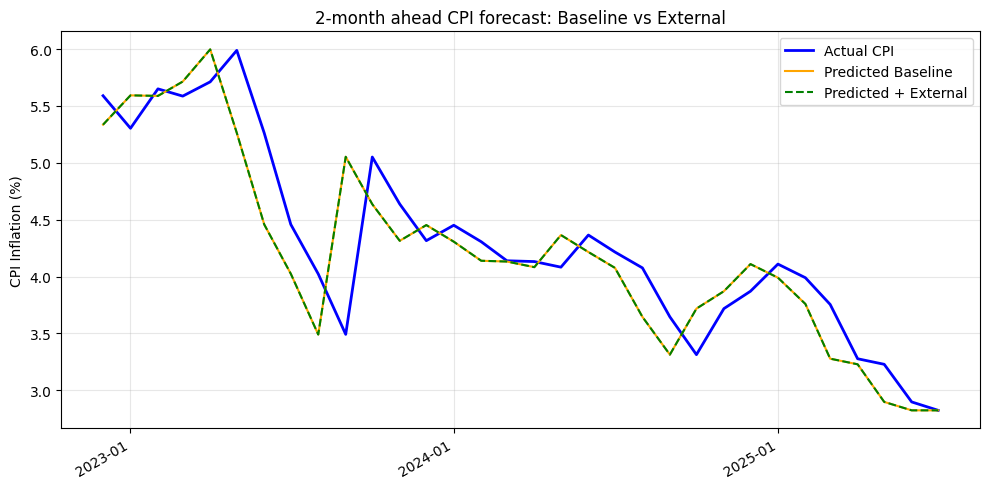

In [8]:
# ==============================
# STEP 6: Run comparison
# ==============================

# Define a rolling window size to experiment with
rolling_window_size = 119

# Baseline CPI-only
df_model_base, features_base, h = prepare_cpi(merged, external_df=None, h=2)
preds_b, actuals_b, dates_b, rmse_b, forecast_b, model_b, scaler_b = rolling_lasso(df_model_base, features_base, h, Rh=rolling_window_size)

# With external data
df_model_ext, features_ext, h = prepare_cpi(merged, external_df=None, h=2)
preds_e, actuals_e, dates_e, rmse_e, forecast_e, model_e, scaler_e = rolling_lasso(df_model_ext, features_ext, h, Rh=rolling_window_size)

print("\n=== Comparison ===")
print(f"Baseline RMSE: {rmse_b:.3f}" if rmse_b is not None else "Baseline RMSE: NA")
print(f"With external data RMSE: {rmse_e:.3f}" if rmse_e is not None else "With external data RMSE: NA")
print(f"Baseline forecast (2m ahead): {forecast_b:.2f}%" if forecast_b is not None else "Baseline forecast: NA")
print(f"External forecast (2m ahead): {forecast_e:.2f}%" if forecast_e is not None else "External forecast: NA")

# Extract actual CPI values from merged dataframe
# Use the inflation column directly
if "Headline Inflation_Eswatini" in merged.columns:
    actual_cpi = merged["Headline Inflation_Eswatini"]
elif "cpi_yoy" in merged.columns:
    actual_cpi = merged["cpi_yoy"]
else:
    # Compute if needed
    actual_cpi = 100 * (merged["CPI_Index"] / merged["CPI_Index"].shift(12) - 1)

# Align actual CPI with prediction dates
actual_cpi_aligned = actual_cpi.reindex(dates_b)

# Plot comparison
import matplotlib.dates as mdates
plt.figure(figsize=(10,5))
plt.plot(dates_b, actual_cpi_aligned, label="Actual CPI", linewidth=2, color='blue')
plt.plot(dates_b, preds_b, label="Predicted Baseline", linewidth=1.5, color='orange')
plt.plot(dates_e, preds_e, label="Predicted + External", linestyle="--", linewidth=1.5, color='green')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("2-month ahead CPI forecast: Baseline vs External")
plt.ylabel("CPI Inflation (%)")

# Format the x-axis as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [ ]:
# Get September forecast (h=2 from last data point in July)
df_model, features, h_sept = prepare_cpi(merged, external_df=None, h=2)
preds_sept, actuals_sept, pred_dates_sept, rmse_sept, forecast_sept, model_sept, scaler_sept = rolling_lasso(
    df_model, features, h=h_sept, Rh=rolling_window_size
)

# Get October forecast (h=3 from last data point in July)
df_model, features, h_oct = prepare_cpi(merged, external_df=None, h=3)
preds_oct, actuals_oct, pred_dates_oct, rmse_oct, forecast_oct, model_oct, scaler_oct = rolling_lasso(
    df_model, features, h=h_oct, Rh=rolling_window_size
)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'ID': ['September_headline', 'October_headline'],
    'Value': [forecast_sept, forecast_oct]
})

# Display and save
display(submission_df)
submission_df.to_csv('submission.csv', index=False)

Initial merged dataframe shape: (152, 115)
Initial date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
✅ Using Headline Inflation_Eswatini as base inflation feature

--- Missing value handling ---

✅ Final modeling dataset shape: (152, 10)
Date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
Feature count: 9

Rolling LASSO Backtest completed:
Window (Rh): 119 | Horizon (h): 2 | RMSE: 0.0117 (32 valid predictions out of 32)
Final model trained with best alpha: 0.0005590810182512228
Final 2-month ahead forecast: 2.8009
Initial merged dataframe shape: (152, 115)
Initial date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
✅ Using Headline Inflation_Eswatini as base inflation feature

--- Missing value handling ---

✅ Final modeling dataset shape: (152, 10)
Date range: 2012-12-01 00:00:00 → 2025-07-01 00:00:00
Feature count: 9

Rolling LASSO Backtest completed:
Window (Rh): 119 | Horizon (h): 3 | RMSE: 0.0095 (31 valid predictions out of 31)
Final model trained with best alpha: 1e-06
F

,ID,Value
0,September_headline,2.800890
1,October_headline,2.867486
